# Описание задания
А/А-тестирование мобильного приложения. 

Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

Описание колонок
experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки
 

### Задача


Запустите A/A-тест

Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
Посчитайте pvalue для каждой версии МП

Найдите версии, где pvalue < 0.05

Исключите версию с pvalue < 0.05 из основного датафрейма

Повторно запустите расчет FPR через A/A. Теперь FPR < альфа

Вы нашли поломку

In [1]:
#Импортируем библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
#Считаем файл
df=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-inchenko-23/hw_aa.csv', sep=';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [4]:
#Конверсия в покупку по группам
df.groupby('experimentVariant').agg({'purchase':'mean'})

,purchase
experimentVariant,
0,0.023945
1,0.053242


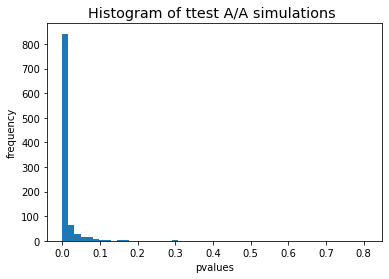

0.94

In [5]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant== 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Видим, что АА-тест не сходится, так как количество ложноположительных случаев сильно превышает предельно допустимый уровень альфа. Поэтому надо найти и устранить поломку.

In [6]:
#Чтобы найти, где поломка, посмотрим на агрегированные значения.
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase':'mean', 'uid':'nunique'}).rename(columns={'uid':'numUsers'})

,experimentVariant,version,purchase,numUsers
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Видим, что со сплитованием все ок, а вот с конверсией покупки есть поломки. Посмотрим на версию v2.8.0, у которой в 0 эксперименте конверсия 0%, а в эксперименте 1 конверсия 4,5%. Очевидно, значение 0 неверно

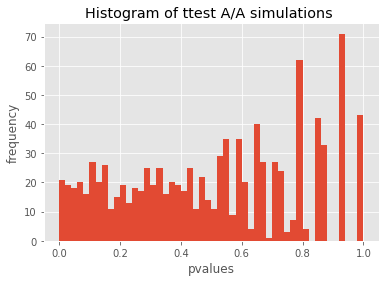

0.048

In [7]:
#Уберем нашу поломку из AA-теста и посмотрим на новый результат
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != "v2.8.0")]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant== 0) & (df.version != "v2.8.0")]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Действительно, причина поломки была в версии мобильного приложения v2.8.0, так как без нее АА-тест работает верно.